In [69]:
import re
import string
from sklearn.preprocessing import StandardScaler, LabelEncoder
import nltk
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter 
from sklearn.linear_model import LogisticRegression
from gensim.models import Word2Vec

from nltk import word_tokenize
from nltk.corpus import stopwords

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score

nltk.download("stopwords")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn import preprocessing
from tqdm import tqdm
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from tensorflow.keras.layers import BatchNormalization
from keras.utils import np_utils
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
stop_words = stopwords.words("english")
import tensorflow as tf
import string
import re
from collections import Counter
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

[nltk_data] Downloading package stopwords to /Users/manoj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
#Put in the file path to the dataset created from extractingauthors.ipynb
df = pd.read_csv("./enron.csv")
df = df.drop(["Email Folder"], axis=1)
#We need only the top 20 authors ordered by number of emails found in either the
#sent folder or _sent_mail folder

#Add top_authors = df.value_counts(["Folder"])[:X] for the number of authors required
# Change X to 5,10,15 to test with 5, 10, 15 authors
top_authors = df.value_counts(["Folder"])[:5]
df = df.loc[df["Folder"].isin(list(top_authors.index.get_level_values(0)))].drop(["Unnamed: 0"], axis=1).reset_index(drop=True)
df = df[df["Text"]!=" "]
df = df[df["Text"]!="\n"]
df = df.dropna()
df.head()

,Author,Folder,File,Message ID,Text,Raw Text
0,Vince J,kaminski-v,2191.0,9763257.1075856555112.,"Pierre-Philippe,\n\nI have contacted Allison B...",Message-ID: <9763257.1075856555112.JavaMail.ev...
1,Vince J,kaminski-v,1693.0,31194175.1075856543039.,"Martin,\n\nCan you, please, call Shu and provi...",Message-ID: <31194175.1075856543039.JavaMail.e...
2,Vince J,kaminski-v,1952.0,4743153.1075856549060.,UPS Tracking numbers\n,Message-ID: <4743153.1075856549060.JavaMail.ev...
3,Vince J,kaminski-v,4054.0,8413088.1075856988030.,"Steve,\n\nThe schedule is fine with me. One co...",Message-ID: <8413088.1075856988030.JavaMail.ev...
4,Vince J,kaminski-v,1023.0,20177981.1075856527141.,"Zimin,\n\nCan you interview this guy? Maybe Ta...",Message-ID: <20177981.1075856527141.JavaMail.e...


Here we are using the enron.csv file created from the noteboook "STEP2_ExtractingAuthorEmails.ipynb". This csv contains all the sent emails from 20 authors, and the extracted body of text from each email. 
You can change the X value too 5,10,15 to test with the corresponding number of authors. Here we are testing with 5 authors.

In [5]:
df["Folder"].value_counts()

mann-k          8167
kaminski-v      5926
dasovich-j      4805
germany-c       4571
shackleton-s    4003
Name: Folder, dtype: int64

In [23]:
def uniform_distribution(samples_per_author, df):
    df3 = pd.DataFrame(columns=["Author", "Folder", "File", "Text", "Raw Text"]) 
    for folder in df["Folder"].value_counts().index:
        df3 = df3.append(df[df["Folder"]==folder].sample(n=samples_per_author), ignore_index=True)
    return df3

In [25]:
# Change the number of samples per author here
df = uniform_distribution(4000, df)
print(df["Folder"].value_counts())

mann-k          4000
kaminski-v      4000
dasovich-j      4000
germany-c       4000
shackleton-s    4000
Name: Folder, dtype: int64


The function uniform_distribution is used to sample the appropriate number of emails from the number of chosen authors. As you can initially see the number of emails per author is unbalanced with the highest being around 8000 and the lowest being around 4000. To ensure equal distribution we random sampled 4000 emails from each of the 5 authors. 

In [26]:
def text_process(text):
    #Remove Punctuation Marks
    text = text.lower()
    nopunct = ""
    clean_final = []
    for char in text:
        if re.match(r"\w", char) or re.match(r" ", char):
            nopunct += char
        elif re.match(r" ", char):
            nopunct += char
        else:
            nopunct += " "
    for word in nopunct.split():
        if not word in stop_words:
            clean_final.append(word)
    nopunct=" ".join(clean_final)
    return nopunct

In [27]:
#Process all the text in each row in the df dataset
proccessed_text = df["Text"].apply(lambda row: text_process(row))
proccessed_text

0        great ge brett rep john ayres initially pages ...
1        brian sure understand objection wording guaran...
2        mean literally across street yikes making toug...
3                                              next monday
4                                                 fun file
                               ...                        
19995    lawyer apea call let know confirm sent apea se...
19996    faxing copy statement submitted ubs enron corp...
19997    confirmation desk recently received call mike ...
19998    susan attached electronic agreements ena tradi...
19999                                                 fine
Name: Text, Length: 20000, dtype: object

In [28]:
df["Processed Text"] = proccessed_text

Here we are doing text preprocessing - remove all non alphanumeric characters, and removing the stop words, and adding that as a column to the dataframe

In [29]:
tokenized_text = df["Processed Text"].apply(lambda row: word_tokenize(row))
df["Tokens"] = tokenized_text
df["Tokens"]

0        [great, ge, brett, rep, john, ayres, initially...
1        [brian, sure, understand, objection, wording, ...
2        [mean, literally, across, street, yikes, makin...
3                                           [next, monday]
4                                              [fun, file]
                               ...                        
19995    [lawyer, apea, call, let, know, confirm, sent,...
19996    [faxing, copy, statement, submitted, ubs, enro...
19997    [confirmation, desk, recently, received, call,...
19998    [susan, attached, electronic, agreements, ena,...
19999                                               [fine]
Name: Tokens, Length: 20000, dtype: object

Converting the processed text to tokens which will then be used to find the vector in the Glove pretrained vector model

In [30]:
y = df["Folder"]
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(y)

In [31]:
entire_corpus_emails = df["Processed Text"].tolist()
entire_corpus_text = " ".join(entire_corpus_emails)
all_words = entire_corpus_text.split()
all_unique_words = set(all_words)

In [32]:
all_unique_tokens = list(set([a for b in df["Tokens"].tolist() for a in b]))
print("Number of unique tokens {}".format(len(all_unique_tokens)))
print("Number of unique words {}".format(len(all_unique_words)))

Number of unique tokens 23714
Number of unique words 23714


Here we are label encoding our target variable Y, which in this case is the folder name or author name of the sent email. 

Then we are creating a set that contains all the unique words seen in the entire "Processed Text" column of the enron.csv file. 

In [33]:
def create_glove_vector_dictionary(unique_tokens, f):
    glove_word_dict = {}
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        if word in unique_tokens:
            coefs = np.asarray(values[1:], dtype='float32')
            glove_word_dict[word] = coefs
    return glove_word_dict    

In [15]:
GLOVE_DATASET_PATH = "../glove.42B.300d.txt"
f = open(GLOVE_DATASET_PATH)
glove_word_dict = create_glove_vector_dictionary(all_unique_tokens, f)
f.close()

1917495it [28:33, 1118.91it/s]


Here we are opening up the pretrained glove vector model - Common Crawl with 42 billion tokens and 300 dimensional vector, and using the function create_glove_vector_dictionary to map each word seen in the email corpus to the appropriate pre-trained vector according to GLoVe. This process takes about 30 minutes

In [34]:
print("Total number of unique words = {}".format(len(all_unique_words)))
print("Number of words found in Glove = {}".format(len(glove_word_dict.keys())))

Total number of unique words = 23714
Number of words found in Glove = 22811


In [16]:
# with open('glove_word_dict.json', 'wb') as fp:
#     pickle.dump(glove_word_dict, fp)

Use the above to save the glove_word_dictionary created earlier, to avoid having to repeatedly use the glove.42B.300d.txt file to search.

In [35]:
def glove_vectorizer(tokenized_text, glove_word_dict):
    features = []
    zero_vector = np.zeros(300)
    vectors = []
    word_counter = 0
    for word in tokenized_text:
        if word in glove_word_dict.keys():
            vectors.append(glove_word_dict[word])
            word_counter += 1
    if vectors:
        vectors = np.asarray(vectors)
        avg_vectors = vectors.mean(axis=0)
        return avg_vectors
    else:
        return zero_vector
        

This function takes input of a list of tokens, and a glove word dictionary where the key is the token and the value is it's 300d vector. The function then goes through all the tokens and finds the appropriate glove vector and appends the found vector to a list called vectors. 
To represent the all the word vectors present in the list vectors, we take the average of the vectors and return that to represent the list of tokens passed into the function. If none of the tokens passed in were found in the glove word dictionary a zero vector is returned.

In [36]:
# To spend up test times use this function
def create_train_glove_dictionary(unique_tokens):
    with open('glove_word_dict.json', 'rb') as fp:
        og_dict = pickle.load(fp)
    train_dict = {}
    for word in unique_tokens:
        if word in og_dict.keys():
            train_dict[word] = og_dict[word]
    return train_dict

In [37]:
X = df["Tokens"]
kf = KFold(n_splits=10, random_state=1, shuffle=True)
i = 1
clf = RandomForestClassifier()
training_accuracy = []
testing_accuracy = []
for train_index, test_index in kf.split(X):
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    
    print("Round {}".format(i))
    print("X_Train Shape")
    print(X_train.shape)
    print("X_Test Shape")
    print(X_test.shape)
    
    all_unique_tokens = list(set([a for b in X_train.tolist() for a in b]))
    print("Number of unique tokens {}".format(len(all_unique_tokens)))
    print()
    
    #This will take super long, so instead create the smaller training dictionary from the og_dict
#     GLOVE_DATASET_PATH = "./glove.42B.300d.txt"
#     f = open(GLOVE_DATASET_PATH)
#     glove_word_dict = create_glove_vector_dictionary(all_unique_tokens, f)
#     f.close()

    glove_word_dict = create_train_glove_dictionary(all_unique_tokens)
    
    print("Number of unique tokens {}".format(len(all_unique_tokens)))
    print("Number of words found in Glove = {}".format(len(glove_word_dict.keys())))
    
    X_train_vectors = X_train.apply(lambda row: glove_vectorizer(row, glove_word_dict))
    X_test_vectors = X_test.apply(lambda row: glove_vectorizer(row, glove_word_dict))
    
    X_train_vectors = np.array(X_train_vectors.tolist())
    X_test_vectors = np.array(X_test_vectors.tolist())
    
    print("X_train vectors")
    print(X_train_vectors.shape)
    print("X_test vectors")
    print(X_test_vectors.shape)
    
    clf.fit(X_train_vectors, y_train)
    training_accuracy.append(clf.score(X_train_vectors, y_train))
    testing_accuracy.append(clf.score(X_test_vectors, y_test))
    print("Training Accuracy - {}".format(training_accuracy[i-1]))
    print("Testing Accuracy - {}".format(testing_accuracy[i-1]))
    i = i + 1
print("Average Training Accuracy")
print(sum(training_accuracy)/len(training_accuracy))
print("Average Testing Accuracy")
print(sum(testing_accuracy)/len(testing_accuracy))

Round 1
X_Train Shape
(18000,)
X_Test Shape
(2000,)
Number of unique tokens 22690

Number of unique tokens 22690
Number of words found in Glove = 19430
X_train vectors
(18000, 300)
X_test vectors
(2000, 300)
Training Accuracy - 0.9741111111111111
Testing Accuracy - 0.804
Round 2
X_Train Shape
(18000,)
X_Test Shape
(2000,)
Number of unique tokens 22776

Number of unique tokens 22776
Number of words found in Glove = 19528
X_train vectors
(18000, 300)
X_test vectors
(2000, 300)
Training Accuracy - 0.9747222222222223
Testing Accuracy - 0.7775
Round 3
X_Train Shape
(18000,)
X_Test Shape
(2000,)
Number of unique tokens 22859

Number of unique tokens 22859
Number of words found in Glove = 19598
X_train vectors
(18000, 300)
X_test vectors
(2000, 300)
Training Accuracy - 0.9746666666666667
Testing Accuracy - 0.795
Round 4
X_Train Shape
(18000,)
X_Test Shape
(2000,)
Number of unique tokens 22820

Number of unique tokens 22820
Number of words found in Glove = 19538
X_train vectors
(18000, 300)
X_

Here we are taking the Tokens column and do 10 fold cross validation with Glove Vector and RandomForests.
The unique training data tokens are found and then passed into create_train_glove_dictionary to create a subset of the glove_word_dictionary that was created using all the unique tokens from the entire dataset. This is done so that the training data and testing data are kept separate, but also to be able to have a faster runtime, as it would take a lot of time to do 10 fold cross validation using the Glove Vector file. Using the glove_word_dictionary created originally we create a smaller dictionary that consists of only the tokens seen in the training data. 
We then use the glove vectorizer to vectorize the tokens per email, and get one 300d vector representing the entire email. 
We then use the RandomForest to get our training and testing accuracies.
Average Training Accuracy
0.9748666666666669
Average Testing Accuracy
0.7849999999999999

In [118]:
X = df["Tokens"]
kf = KFold(n_splits=10, random_state=1, shuffle=True)
i = 1
clf = LogisticRegression(n_jobs=1, C=1e5, max_iter=100000)
training_accuracy = []
testing_accuracy = []
for train_index, test_index in kf.split(X):
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    
    print("Round {}".format(i))
    print("X_Train Shape")
    print(X_train.shape)
    print("X_Test Shape")
    print(X_test.shape)
    
    all_unique_tokens = list(set([a for b in X_train.tolist() for a in b]))
    print("Number of unique tokens {}".format(len(all_unique_tokens)))
    print()
    
    #This will take super long, so instead create the smaller training dictionary from the og_dict
#     GLOVE_DATASET_PATH = "./glove.42B.300d.txt"
#     f = open(GLOVE_DATASET_PATH)
#     glove_word_dict = create_glove_vector_dictionary(all_unique_tokens, f)
#     f.close()

    glove_word_dict = create_train_glove_dictionary(all_unique_tokens)
    
    print("Number of unique tokens {}".format(len(all_unique_tokens)))
    print("Number of words found in Glove = {}".format(len(glove_word_dict.keys())))
    
    X_train_vectors = X_train.apply(lambda row: glove_vectorizer(row, glove_word_dict))
    X_test_vectors = X_test.apply(lambda row: glove_vectorizer(row, glove_word_dict))
    
    X_train_vectors = np.array(X_train_vectors.tolist())
    X_test_vectors = np.array(X_test_vectors.tolist())
    
    print("X_train vectors")
    print(X_train_vectors.shape)
    print("X_test vectors")
    print(X_test_vectors.shape)
    
    
    clf.fit(X_train_vectors, y_train)
    training_accuracy.append(clf.score(X_train_vectors, y_train))
    testing_accuracy.append(clf.score(X_test_vectors, y_test))
    print("Training Accuracy - {}".format(training_accuracy[i-1]))
    print("Testing Accuracy - {}".format(testing_accuracy[i-1]))
    i = i + 1
print("Average Training Accuracy")
print(sum(training_accuracy)/len(training_accuracy))
print("Average Testing Accuracy")
print(sum(testing_accuracy)/len(testing_accuracy))

Round 1
X_Train Shape
(18000,)
X_Test Shape
(2000,)
Number of unique tokens 22563

Number of unique tokens 22563
Number of words found in Glove = 20495
X_train vectors
(18000, 300)
X_test vectors
(2000, 300)
Training Accuracy - 0.7887222222222222
Testing Accuracy - 0.76
Round 2
X_Train Shape
(18000,)
X_Test Shape
(2000,)
Number of unique tokens 22564

Number of unique tokens 22564
Number of words found in Glove = 20506
X_train vectors
(18000, 300)
X_test vectors
(2000, 300)
Training Accuracy - 0.7862777777777777
Testing Accuracy - 0.7645
Round 3
X_Train Shape
(18000,)
X_Test Shape
(2000,)
Number of unique tokens 22444

Number of unique tokens 22444
Number of words found in Glove = 20386
X_train vectors
(18000, 300)
X_test vectors
(2000, 300)
Training Accuracy - 0.7887777777777778
Testing Accuracy - 0.763
Round 4
X_Train Shape
(18000,)
X_Test Shape
(2000,)
Number of unique tokens 22504

Number of unique tokens 22504
Number of words found in Glove = 20468
X_train vectors
(18000, 300)
X_t

Here we use Logistic Regression to get our training and testing accuracies.
Average Training Accuracy
0.7874000000000001
Average Testing Accuracy
0.7655500000000001

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True, stratify=y)


all_unique_tokens = list(set([a for b in X_train.tolist() for a in b]))
print("Number of unique tokens {}".format(len(all_unique_tokens)))
print()

glove_word_dict = create_train_glove_dictionary(all_unique_tokens)
    
print("Number of unique tokens {}".format(len(all_unique_tokens)))
print("Number of words found in Glove = {}".format(len(glove_word_dict.keys())))
    
X_train_vectors = X_train.apply(lambda row: glove_vectorizer(row, glove_word_dict))
X_test_vectors = X_test.apply(lambda row: glove_vectorizer(row, glove_word_dict))

X_train_vectors = np.array(X_train_vectors.tolist())
X_test_vectors = np.array(X_test_vectors.tolist())

print("X_train vectors")
print(X_train_vectors.shape)
print("X_test vectors")
print(X_test_vectors.shape)

parameters = {"C": [1.0, 10], "gamma": [1, 'auto', 'scale']}


model = GridSearchCV(SVC(kernel='rbf'), parameters, cv=10, n_jobs=-1).fit(X_train_vectors, y_train)
training_accuracy = model.score(X_train_vectors, y_train)
testing_accuracy = model.score(X_test_vectors, y_test)
print("Training Accuracy")
print(training_accuracy)
print("Testing Accuracy")
print(testing_accuracy)

Number of unique tokens 20215

Number of unique tokens 20215
Number of words found in Glove = 17515
X_train vectors
(13400, 300)
X_test vectors
(6600, 300)
Training Accuracy
0.9305970149253732
Testing Accuracy
0.825


Here we are using train test split to first intially find the best parameters for Support Vector Machine. With the best parameters using train test split we are getting
Training Accuracy
0.9305970149253732
Testing Accuracy
0.825

In [67]:
model.best_params_

{'C': 10, 'gamma': 'scale'}

In [39]:
X = df["Tokens"]
kf = KFold(n_splits=10, random_state=1, shuffle=True)
i = 1
clf = model # Referencing the previous Support Vector Classifier with the best parameters
training_accuracy = []
testing_accuracy = []
for train_index, test_index in kf.split(X):
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    
    print("Round {}".format(i))
    print("X_Train Shape")
    print(X_train.shape)
    print("X_Test Shape")
    print(X_test.shape)
    
    all_unique_tokens = list(set([a for b in X_train.tolist() for a in b]))
    print("Number of unique tokens {}".format(len(all_unique_tokens)))
    print()
    
    #This will take super long, so instead create the smaller training dictionary from the og_dict
#     GLOVE_DATASET_PATH = "./glove.42B.300d.txt"
#     f = open(GLOVE_DATASET_PATH)
#     glove_word_dict = create_glove_vector_dictionary(all_unique_tokens, f)
#     f.close()

    glove_word_dict = create_train_glove_dictionary(all_unique_tokens)
    
    print("Number of unique tokens {}".format(len(all_unique_tokens)))
    print("Number of words found in Glove = {}".format(len(glove_word_dict.keys())))
    
    X_train_vectors = X_train.apply(lambda row: glove_vectorizer(row, glove_word_dict))
    X_test_vectors = X_test.apply(lambda row: glove_vectorizer(row, glove_word_dict))
    
    X_train_vectors = np.array(X_train_vectors.tolist())
    X_test_vectors = np.array(X_test_vectors.tolist())
    
    print("X_train vectors")
    print(X_train_vectors.shape)
    print("X_test vectors")
    print(X_test_vectors.shape)
    
    
    clf.fit(X_train_vectors, y_train)
    training_accuracy.append(clf.score(X_train_vectors, y_train))
    testing_accuracy.append(clf.score(X_test_vectors, y_test))
    print("Training Accuracy - {}".format(training_accuracy[i-1]))
    print("Testing Accuracy - {}".format(testing_accuracy[i-1]))
    i = i + 1
print("Average Training Accuracy")
print(sum(training_accuracy)/len(training_accuracy))
print("Average Testing Accuracy")
print(sum(testing_accuracy)/len(testing_accuracy))

Round 1
X_Train Shape
(18000,)
X_Test Shape
(2000,)
Number of unique tokens 22690

Number of unique tokens 22690
Number of words found in Glove = 19430
X_train vectors
(18000, 300)
X_test vectors
(2000, 300)
Training Accuracy - 0.9276666666666666
Testing Accuracy - 0.846
Round 2
X_Train Shape
(18000,)
X_Test Shape
(2000,)
Number of unique tokens 22776

Number of unique tokens 22776
Number of words found in Glove = 19528
X_train vectors
(18000, 300)
X_test vectors
(2000, 300)
Training Accuracy - 0.9293888888888889
Testing Accuracy - 0.825
Round 3
X_Train Shape
(18000,)
X_Test Shape
(2000,)
Number of unique tokens 22859

Number of unique tokens 22859
Number of words found in Glove = 19598
X_train vectors
(18000, 300)
X_test vectors
(2000, 300)
Training Accuracy - 0.9294444444444444
Testing Accuracy - 0.84
Round 4
X_Train Shape
(18000,)
X_Test Shape
(2000,)
Number of unique tokens 22820

Number of unique tokens 22820
Number of words found in Glove = 19538
X_train vectors
(18000, 300)
X_te

Using the best parameters for SVM, we are doing 10 fold cross validation. 
Average Training Accuracy
0.9291944444444444
Average Testing Accuracy
0.8346

In [50]:
glove_training_acc_rf = 0.9748666666666669 * 100
glove_testing_acc_rf = 0.7849999999999999 * 100
glove_training_acc_lr = 0.7874000000000001 * 100
glove_testing_acc_lr = 0.7655500000000001 * 100
glove_training_acc_svm = 0.9291944444444444 * 100
glove_testing_acc_svm = 0.8346 * 100
training_acc = [glove_training_acc_rf, glove_training_acc_lr, glove_training_acc_svm]
testing_acc = [glove_testing_acc_rf, glove_testing_acc_lr, glove_testing_acc_svm]

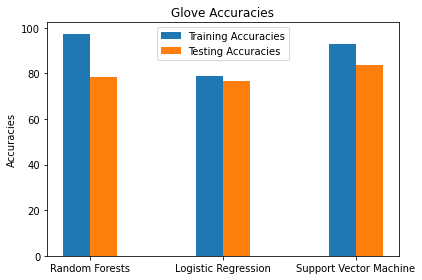

In [68]:
labels = ["Random Forests", "Logistic Regression", "Support Vector Machine"]
x = np.arange(len(labels))
width = 0.2
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, training_acc, width, label='Training Accuracies')
rects2 = ax.bar(x + width/2, testing_acc, width, label='Testing Accuracies')
ax.set_ylabel('Accuracies')
ax.set_title('Glove Accuracies')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()

plt.show()

Plotting the average training and testing accuracies after 10 Fold Cross Validation for each all the classifiers used. 
We can see that Support Vector Machine has the best accuracy. 

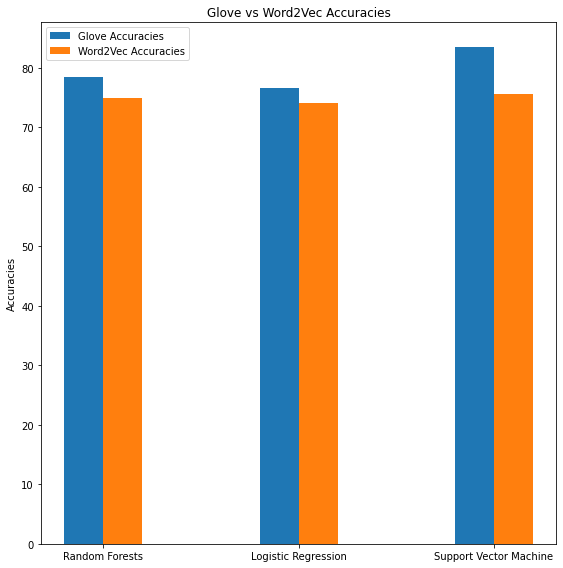

In [76]:
wordvec_testing_acc_rf = 0.74885 * 100
wordvec_testing_acc_lr = 0.7414 * 100
wordvec_acc_svm = 0.7556999999999999 * 100
glove_testing_acc = [glove_testing_acc_rf, glove_testing_acc_lr, glove_testing_acc_svm]
wordvec_testing_acc = [wordvec_testing_acc_rf, wordvec_testing_acc_lr, wordvec_acc_svm]
labels = ["Random Forests", "Logistic Regression", "Support Vector Machine"]
x = np.arange(len(labels))
width = 0.2
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, glove_testing_acc, width, label='Glove Accuracies')
rects2 = ax.bar(x + width/2, wordvec_testing_acc, width, label='Word2Vec Accuracies')
ax.set_ylabel('Accuracies')
ax.set_title('Glove vs Word2Vec Accuracies')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()
plt.rcParams["figure.figsize"] =(7,7)
plt.show()